# Create meta-fields

In [1]:
### The dataset to use in this analysis
DATASET_USED = '2YCOMPAS'
# DATASET_USED = 'BSCOMPAS'
# DATASET_USED = 'RDCOMPAS'

### Fields accessible to use in rationalization?
### ... some of which are VERY unfair and/or illegal
ACCESSIBLE_FIELDS = [
    # 'sex', # >:(
    # 'race', # >:(
    # 'age', # >:(
    # 'age_cat',
    'juv_fel_count',
    'juv_misd_count',
    'juv_other_count',
    'priors_count',
    'c_charge_degree',
    'c_charge_desc',
]

### Field that is the source of what we are rationalizing based on
# TRUERESULT_FIELD = 'two_year_recid'
TRUERESULT_FIELD = 'is_recid'
### Field we are trying to rationalize why it could be 1 vs 0
JUSTIFYING_FIELD = 'is_recid' # not going to use 'is_violent_recid' much here
# JUSTIFYING_FIELD = 'two_year_recid'
### Field that is 1 if justifying==trueresult, otherwise 0.
### This is DEFINED BY ME AND NOT IN THE ORIGINAL DATA
WASCORRECT_FIELD = 'pred_accurate'

### Threshold for confidence range
CONF_ALPHA = 0.05

### Seed to begin with in 'train'/'test' split sampling
SAMPLING_SEED = 1
### Ratio of 'train'/'test' split sampling
SPLIT_RATIO = 0.8
### Number of runs to try (increments seed by 1 repeatedly)
NUM_RUNS = 5
### Maximum number of factors to include in the whole-dataset evaluation
MAX_RATEXPL_FACTORS = 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

In [3]:
from os.path import exists

# Handle dataset

## Load dataset (pick ONE)

### (2YCOMPAS) Import and parse COMPAS dataset similar to ProPublica's method

In [4]:
if DATASET_USED=='2YCOMPAS':
    raw_data_df = pd.read_csv("data-compas/compas-scores-two-years.csv")
    # Print preview of contents
    raw_data_df.shape
    raw_data_df[:5]

(7214, 53)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [5]:
# see: https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb
if DATASET_USED=='2YCOMPAS':
    filter_data_df = raw_data_df
    filter_data_df = filter_data_df[filter_data_df['days_b_screening_arrest'] >= -30]
    filter_data_df = filter_data_df[filter_data_df['days_b_screening_arrest'] <= 30]
    filter_data_df = filter_data_df[filter_data_df['is_recid'] != -1]
    filter_data_df = filter_data_df[filter_data_df['c_charge_degree'] != 'O']
    filter_data_df = filter_data_df[filter_data_df['score_text'] != 'N/A']
    filter_data_df.shape

(6172, 53)

### (RDCOMPAS) Build an shuffled version of the COMPAS dataset, using same filters as ProPublica

Shuffled dataset randomizes the "predictions" made. The same overall percentage of predictions are still there, they are just randomized among the entire dataset.

In [6]:
rdcompas_data_path = f'data-randomcompas/shuffled_filtered.pkl'
# if randomized data doesn't exist, make it
if DATASET_USED=='RDCOMPAS' and not exists(rdcompas_data_path):
    raw_data_df = pd.read_csv("data-compas/compas-scores-two-years.csv")
    # Print preview of contents
    raw_data_df.shape
    # do the same filter as used for 2YCOMPAS
    filter_data_df = raw_data_df
    filter_data_df = filter_data_df[filter_data_df['days_b_screening_arrest'] >= -30]
    filter_data_df = filter_data_df[filter_data_df['days_b_screening_arrest'] <= 30]
    filter_data_df = filter_data_df[filter_data_df['is_recid'] != -1]
    filter_data_df = filter_data_df[filter_data_df['c_charge_degree'] != 'O']
    filter_data_df = filter_data_df[filter_data_df['score_text'] != 'N/A']
    filter_data_df.shape
    # Create shuffle
    filter_data_df[JUSTIFYING_FIELD] = np.random.permutation(filter_data_df[JUSTIFYING_FIELD].values)
    # Backup the contents
    filter_data_df.to_pickle(rdcompas_data_path)

In [7]:
if DATASET_USED=='RDCOMPAS':
    # load backups
    filter_data_df = pd.read_pickle(rdcompas_data_path)
    # Print preview of contents
    filter_data_df.shape
    filter_data_df[:5]

### (BSCOMPAS) Build a malicious version of the COMPAS dataset, using same filters as ProPublica

Malicious COMPAS biases strictly by race. The same overall percentage of predictions are there, just people with certain races are "predicted" as positive far more. (Generated by "filling" up those race groups with positive prediction with priority until final positive prediction count is the same)

In [8]:
bscompas_data_path = f'data-badcompas/malicious_filtered.pkl'
# if randomized data doesn't exist, make it
if DATASET_USED=='BSCOMPAS' and not exists(bscompas_data_path):
    raw_data_df = pd.read_csv("data-compas/compas-scores-two-years.csv")
    # do the same filter as used for 2YCOMPAS
    filter_data_df = raw_data_df
    filter_data_df = filter_data_df[filter_data_df['days_b_screening_arrest'] >= -30]
    filter_data_df = filter_data_df[filter_data_df['days_b_screening_arrest'] <= 30]
    filter_data_df = filter_data_df[filter_data_df['is_recid'] != -1]
    filter_data_df = filter_data_df[filter_data_df['c_charge_degree'] != 'O']
    filter_data_df = filter_data_df[filter_data_df['score_text'] != 'N/A']
    filter_data_df.shape
    # Count how many positive preds there ought to be...
    num_pos_pred = sum(filter_data_df[JUSTIFYING_FIELD].values)
    # Sort by race and apply positive predictions from 1->0 strictly in alphabetic race order
    filter_data_df = filter_data_df.sort_values(f'race')
    filter_data_df[JUSTIFYING_FIELD] = [
        (1 if i<num_pos_pred else 0) 
        for i in range(len(filter_data_df))
    ]
    filter_data_df = filter_data_df.sort_index()
    # Backup the contents
    filter_data_df.to_pickle(bscompas_data_path)

In [9]:
if DATASET_USED=='BSCOMPAS':
    # load backups
    filter_data_df = pd.read_pickle(bscompas_data_path)
    # Print preview of contents
    filter_data_df.shape
    filter_data_df[:5]

## Create "prediction was correct" column

In [10]:
filter_data_df[WASCORRECT_FIELD] = filter_data_df.apply(
    lambda r: 1 if r[JUSTIFYING_FIELD]==r[TRUERESULT_FIELD] else 0, 
    axis='columns'
)

## Split data into "training", "test"

In [11]:
filter_data_df_src = filter_data_df.sample(n=int(SPLIT_RATIO*len(filter_data_df)), random_state=SAMPLING_SEED)
filter_data_df_test = filter_data_df[~filter_data_df.index.isin(filter_data_df_src.index)]

print(f' filter_data_df_src shape: {filter_data_df_src.shape}')
print(f'filter_data_df_test shape: {filter_data_df_test.shape}')

 filter_data_df_src shape: (4937, 54)
filter_data_df_test shape: (1235, 54)


# Define rationalization

In [12]:
from statsmodels.stats import proportion

def rationalize(target, data_df, numfields=1):
    def noIntervalOverlap(a1, a2, b1, b2):
        if a1>a2 or b1>b2:
            raise ValueError('unexpected bounds')
        if a2<b1 and a1<b1:
            return True
        if b2<a1 and b1<a1:
            return True
        return False
    breakdown = data_df[TRUERESULT_FIELD]
    full_interval = proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=CONF_ALPHA, method='beta')
    result_df = pd.DataFrame()
    field_groups = [[i] for i in range(len(ACCESSIBLE_FIELDS))]
    for _ in range(numfields-1):
        field_groups = [[f+[i] for i in range(len(ACCESSIBLE_FIELDS)) if i>f[-1]] for f in field_groups]
        field_groups = [e for l in field_groups for e in l]
    for field_ids in field_groups:
        field_names = [ACCESSIBLE_FIELDS[i] for i in field_ids]
        subgroup = data_df
        for field in field_names:
            subgroup = subgroup[subgroup[field] == target[field]]
        subgroup_inv = data_df[~data_df.index.isin(subgroup.index)]
        breakdown = subgroup[TRUERESULT_FIELD]
        breakdown_inv = subgroup_inv[TRUERESULT_FIELD]
        preds = subgroup[JUSTIFYING_FIELD]
        preds_inv = subgroup_inv[JUSTIFYING_FIELD]
        corrects = subgroup[WASCORRECT_FIELD]
        corrects_inv = subgroup_inv[WASCORRECT_FIELD]
        if len(breakdown)>0:
            conf_interval = proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=CONF_ALPHA, method='beta')
            invg_interval = proportion.proportion_confint(sum(breakdown_inv), len(breakdown_inv), alpha=CONF_ALPHA, method='beta')
            result_df = result_df.append({
                'field_count': len(field_names),
                'field_key': (tuple(field_names), tuple([target[fn] for fn in field_names])),
                'sample_size': len(breakdown),
                f'{TRUERESULT_FIELD}_mean': sum(breakdown) / len(breakdown),
                f'{JUSTIFYING_FIELD}_mean': sum(preds) / len(preds),
                f'accuracy_mean': sum(corrects) / len(corrects),
                # Confidence interval: in 95% of cases, the true underlying fraction of recidivism will fall within this interval
                # https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Clopper%E2%80%93Pearson_interval
                # https://www.statsmodels.org/devel/generated/statsmodels.stats.proportion.proportion_confint.html
                f'{TRUERESULT_FIELD}_conf_bot': conf_interval[0],
                f'{TRUERESULT_FIELD}_conf_top': conf_interval[1],
                # Statistical significance
                'significant_baseline': 1 if noIntervalOverlap(conf_interval[0], conf_interval[1], full_interval[0], full_interval[1]) else 0,
                # Okay, now... all of this again for the inverse group
                # Results for the inverse group
                f'{TRUERESULT_FIELD}_inv_mean': sum(breakdown_inv) / len(breakdown_inv),
                f'{JUSTIFYING_FIELD}_inv_mean': sum(preds_inv) / len(preds_inv),
                f'accuracy_inv_mean': sum(corrects_inv) / len(corrects_inv),
                'significant_invgroup': 1 if noIntervalOverlap(conf_interval[0], conf_interval[1], invg_interval[0], invg_interval[1]) else 0,
            }, ignore_index=True)
    return result_df

In [13]:
breakdown = filter_data_df_src[TRUERESULT_FIELD]
print('true recidivism (training):', sum(breakdown)/len(breakdown))
print('true recidivism (training) range:', proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=CONF_ALPHA, method='beta'))

print()

breakdown = filter_data_df_test[TRUERESULT_FIELD]
print('true recidivism (testing):', sum(breakdown)/len(breakdown))
print('true recidivism (testing) range:', proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=CONF_ALPHA, method='beta'))

true recidivism (training): 0.48450475997569376
true recidivism (training) range: (0.4704756423271261, 0.49855221487491275)

true recidivism (testing): 0.4842105263157895
true recidivism (testing) range: (0.4559995780324773, 0.5124968091205584)


In [14]:
# Mini-example of selecting someone to justify both-sides of
target = filter_data_df[filter_data_df['id'] == 2680].iloc[0] # filter_data_df.sample(n=1).iloc[0]
filter_data_df[filter_data_df['id'] == target['id']]

rationalize_df = pd.DataFrame()
for numfields in [1,2,3]:
    rationalize_df = rationalize_df.append(
        rationalize(target, filter_data_df_src, numfields=numfields),
        ignore_index=True
    )

# rationalize_df.sort_values(['significant_baseline', f'{TRUERESULT_FIELD}_mean'])
rationalize_df[rationalize_df['significant_baseline'] == 1].sort_values(f'{TRUERESULT_FIELD}_mean')

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,pred_accurate
1766,2680,jazze johnson,jazze,johnson,2013-05-14,Male,1986-09-29,29,25 - 45,African-American,0,8,0,0,0,-1.0,2013-05-13 07:26:35,2013-05-16 03:43:24,13006827CF10A,2013-05-13,NaN,1.0,F,Poss of Cocaine W/I/D/S 1000FT Park,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-05-14,Risk of Violence,4,Low,2013-05-14,2015-05-04,2015-08-19,0,2,720,0,0,1


,field_count,field_key,sample_size,is_recid_mean,accuracy_mean,is_recid_conf_bot,is_recid_conf_top,significant_baseline,is_recid_inv_mean,accuracy_inv_mean,significant_invgroup
31,3.0,"((juv_misd_count, juv_other_count, priors_coun...",1611.0,0.291744,1.0,0.269633,0.314617,1.0,0.577871,1.0,1.0
15,2.0,"((juv_other_count, priors_count), (0, 0))",1612.0,0.292184,1.0,0.270068,0.315058,1.0,0.577744,1.0,1.0
25,3.0,"((juv_fel_count, juv_other_count, priors_count...",1612.0,0.292184,1.0,0.270068,0.315058,1.0,0.577744,1.0,1.0
12,2.0,"((juv_misd_count, priors_count), (0, 0))",1667.0,0.300540,1.0,0.278597,0.323187,1.0,0.578287,1.0,1.0
22,3.0,"((juv_fel_count, juv_misd_count, priors_count)...",1667.0,0.300540,1.0,0.278597,0.323187,1.0,0.578287,1.0,1.0
3,1.0,"((priors_count,), (0,))",1668.0,0.300959,1.0,0.279014,0.323607,1.0,0.578158,1.0,1.0
8,2.0,"((juv_fel_count, priors_count), (0, 0))",1668.0,0.300959,1.0,0.279014,0.323607,1.0,0.578158,1.0,1.0
37,3.0,"((juv_other_count, priors_count, c_charge_degr...",859.0,0.316647,1.0,0.285632,0.348926,1.0,0.519863,1.0,1.0
18,2.0,"((priors_count, c_charge_degree), (0, F))",899.0,0.327030,1.0,0.296417,0.358782,1.0,0.519564,1.0,1.0
28,3.0,"((juv_fel_count, priors_count, c_charge_degree...",899.0,0.327030,1.0,0.296417,0.358782,1.0,0.519564,1.0,1.0


# Visualize small sample of rationalization bounds

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def vis(filter_data_df_src, filter_data_df_test, count_bothsides, count_factors):
    plt.rcParams['figure.figsize'] = [15, 5]
    gap_size = 10
    
    # Randomly select someone to justify negative pred for
    for n in range(count_bothsides):
        target = filter_data_df_test[filter_data_df_test[JUSTIFYING_FIELD] == 0].sample(n=1).iloc[0]
        rationalize_df = pd.DataFrame()
        for numfields in range(1, count_factors+1):
            rationalize_df = rationalize_df.append(
                rationalize(target, filter_data_df_src, numfields=numfields),
                ignore_index=True
            )
        rationalize_df = rationalize_df[rationalize_df['significant_baseline'] == 1]
        dots = plt.scatter(
            [(2*i)+(2*count_factors*n) for i in rationalize_df['field_count']],
            rationalize_df[f'{TRUERESULT_FIELD}_mean'], 
            alpha=[(i/max(rationalize_df['sample_size']))**0.9 for i in rationalize_df['sample_size']]
        )
        for i in range(1, count_factors+1):
            temp_df = rationalize_df[rationalize_df['field_count']==i]
            range_lo = min(temp_df[f'{TRUERESULT_FIELD}_conf_top'])
            range_hi = max(temp_df[f'{TRUERESULT_FIELD}_conf_bot'])
            pos_x = (2*i)+(2*count_factors*n)+1
            # if the bounds overlap and there is no clear gap, then dont draw a line at all
            if (range_lo<=range_hi):
                _ = plt.plot(
                    [pos_x,pos_x], 
                    [range_lo,range_hi],
                    color=dots.get_facecolors()[0][:-1],
                    marker='',
                )

    # Randomly select someone to justify positive pred for
    for n in range(count_bothsides):
        target = filter_data_df_test[filter_data_df_test[JUSTIFYING_FIELD] == 1].sample(n=1).iloc[0]
        rationalize_df = pd.DataFrame()
        for numfields in range(1, count_factors+1):
            rationalize_df = rationalize_df.append(
                rationalize(target, filter_data_df_src, numfields=numfields),
                ignore_index=True
            )
        rationalize_df = rationalize_df[rationalize_df['significant_baseline'] == 1]
        dots = plt.scatter(
            [(2*i)+(2*count_factors*n)+(2*count_factors*count_bothsides)+gap_size for i in rationalize_df['field_count']], 
            rationalize_df[f'{TRUERESULT_FIELD}_mean'], 
            alpha=[(i/max(rationalize_df['sample_size']))**0.9 for i in rationalize_df['sample_size']]
        )
        for i in range(1, count_factors+1):
            temp_df = rationalize_df[rationalize_df['field_count']<=i]
            if len(temp_df)==0:
                pass
            if len(temp_df[f'{TRUERESULT_FIELD}_conf_top'])==0:
                print(temp_df)
                raise ValueError()
            range_lo = min(temp_df[f'{TRUERESULT_FIELD}_conf_top'])
            if len(temp_df[f'{TRUERESULT_FIELD}_conf_bot'])==0:
                print(temp_df)
                raise ValueError()
            range_hi = max(temp_df[f'{TRUERESULT_FIELD}_conf_bot'])
            pos_x = (2*i)+(2*count_factors*n)+(2*count_factors*count_bothsides)+gap_size+1
            # if the bounds overlap and there is no clear gap, then dont draw a line at all
            if (range_lo<=range_hi):
                _ = plt.plot(
                    [pos_x,pos_x], 
                    [range_lo,range_hi],
                    color=dots.get_facecolors()[0][:-1],
                    marker='',
                )
    
    # population mean line
    breakdown = filter_data_df_src[TRUERESULT_FIELD]
    src_range = proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=CONF_ALPHA, method='beta')
    plt.axline((1, sum(breakdown)/len(breakdown)), slope=0, alpha=0.8)
    plt.fill_between(
        [0, 4*count_factors*count_bothsides+gap_size+2], 
        [src_range[1], src_range[1]], 
        [src_range[0], src_range[0]], 
        alpha=0.3
    )
    # 50% line
    plt.axline((1, 0.5), slope=0, alpha=0.4)
    # Modify axis visibility
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    group_fontdict = {'size':'large'}
    ax.text(x=0, y=0.9, s='Predicted low-risk', fontdict=group_fontdict)
    ax.text(x=(2*count_factors*count_bothsides)+gap_size, y=0.9, s='Predicted high-risk', fontdict=group_fontdict)
    ax.set_ylabel('Recidivism rate (dots), confidence gap (lines)', fontdict=group_fontdict)
    ax.set_ylim(bottom=0, top=1)
    # Add bin tags
    plt.show()

In [16]:
# vis(filter_data_df_src, filter_data_df_test, 10, 2)

In [17]:
# vis(filter_data_df_src, filter_data_df_test, 10, 3)

In [18]:
# vis(filter_data_df_src, filter_data_df_test, 20, 2)

In [19]:
# vis(filter_data_df_src, filter_data_df_test, 20, 3)

In [20]:
# vis(filter_data_df_src, filter_data_df_test, 20, 4)

# Calculate rationalization for ALL test set samples

In [21]:
from os.path import exists

# Calculate rationalization for all test set samples
# Backup this rationalization in the 'temp-export/' directory with variable filename depending on global vars
def rationalize_all(df_src, df_test):
    gen_fname = f'{DATASET_USED}_F{JUSTIFYING_FIELD}_T{TRUERESULT_FIELD}_C{CONF_ALPHA}_NF{MAX_RATEXPL_FACTORS}_S{SAMPLING_SEED}'
    backup_path = f'temp-export/{gen_fname}.pkl'
    backup_path_idmerge = f'temp-export/{gen_fname}_idmerge.pkl'
    # if backup doesn't exist, make it
    if (not exists(backup_path)) or (not exists(backup_path_idmerge)):
        test_rationalizations = pd.DataFrame()
        test_rationalizations_idmerge = pd.DataFrame()
        for _, case in df_test.iterrows():
            for numfields in range(1, MAX_RATEXPL_FACTORS+1):
                newrats = rationalize(case, df_src, numfields=numfields)
                test_rationalizations = pd.concat(
                    [
                        test_rationalizations,
                        newrats,
                    ],
                    ignore_index=True,
                )
                newrats['id'] = [case['id'] for _ in range(len(newrats))]
                test_rationalizations_idmerge = pd.concat(
                    [
                        test_rationalizations_idmerge,
                        newrats,
                    ],
                    ignore_index=True,
                )
        # Add column representing the 'side' that each rationalization is in favor of
        breakdown = df_src[TRUERESULT_FIELD]
        justifying_ref_avg = sum(breakdown)/len(breakdown)
        test_rationalizations[f'{JUSTIFYING_FIELD}_rat_side'] = test_rationalizations.apply(
            lambda r: 1 if r[f'{TRUERESULT_FIELD}_mean']>justifying_ref_avg else 0, 
            axis=1
        )
        test_rationalizations_idmerge[f'{JUSTIFYING_FIELD}_rat_side'] = test_rationalizations_idmerge.apply(
            lambda r: 1 if r[f'{TRUERESULT_FIELD}_mean']>justifying_ref_avg else 0, 
            axis=1
        )
        test_rationalizations = test_rationalizations.drop_duplicates()
        # Save backups
        test_rationalizations.to_pickle(backup_path)
        test_rationalizations_idmerge.to_pickle(backup_path_idmerge)
    # load backups
    test_rationalizations = pd.read_pickle(backup_path)
    test_rationalizations_idmerge = pd.read_pickle(backup_path_idmerge)
    return test_rationalizations, test_rationalizations_idmerge

test_rationalizations, test_rationalizations_idmerge = rationalize_all(filter_data_df_src, filter_data_df_test)

In [22]:
test_rationalizations[:2]
test_rationalizations_idmerge[:2]

,field_count,field_key,sample_size,is_recid_mean,accuracy_mean,is_recid_conf_bot,is_recid_conf_top,significant_baseline,is_recid_inv_mean,accuracy_inv_mean,significant_invgroup,is_recid_rat_side
0,1.0,"((juv_fel_count,), (0,))",4760.0,0.473319,1.0,0.459050,0.487621,0.0,0.785311,1.0,1.0,0
1,1.0,"((juv_misd_count,), (0,))",4664.0,0.468696,1.0,0.454291,0.483141,0.0,0.754579,1.0,1.0,0


,field_count,field_key,sample_size,is_recid_mean,accuracy_mean,is_recid_conf_bot,is_recid_conf_top,significant_baseline,is_recid_inv_mean,accuracy_inv_mean,significant_invgroup,id,is_recid_rat_side
0,1.0,"((juv_fel_count,), (0,))",4760.0,0.473319,1.0,0.459050,0.487621,0.0,0.785311,1.0,1.0,4,0
1,1.0,"((juv_misd_count,), (0,))",4664.0,0.468696,1.0,0.454291,0.483141,0.0,0.754579,1.0,1.0,4,0


In [23]:
# Calculate confidence interval of entire training dataset
breakdown = filter_data_df_src[TRUERESULT_FIELD]
src_range = proportion.proportion_confint(sum(breakdown), len(breakdown), alpha=CONF_ALPHA, method='beta')
src_range

(0.4704756423271261, 0.49855221487491275)

## Do solo multi-element rationalizing analysis

### Show distribution of confidence interval gaps

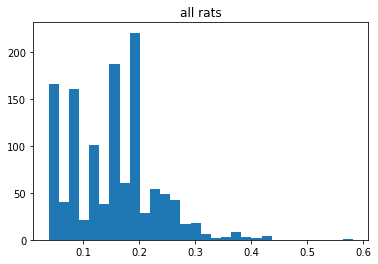

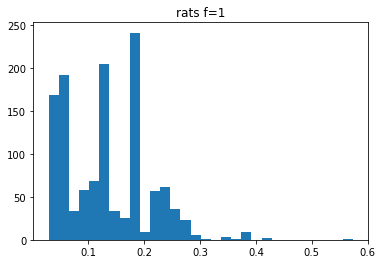

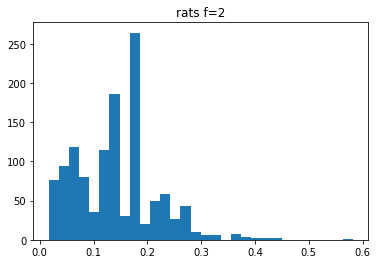

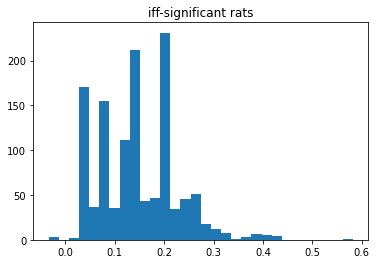

In [24]:
import matplotlib.pyplot as plt
import numpy as np

num_bins = 30

# Compute and show confidence interval gaps between "closest to justify 1" vs "closest to justify 0"
# (negative value means no gap, they overlap)
temp_gaps = []
for x_id, x_rat in test_rationalizations_idmerge.groupby(['id']):
    range_lo = min(x_rat[f'{TRUERESULT_FIELD}_conf_top'])
    range_hi = max(x_rat[f'{TRUERESULT_FIELD}_conf_bot'])
    temp_gaps.append(range_hi-range_lo)

_ = plt.hist(temp_gaps, bins=num_bins)
_ = plt.title('all rats')
plt.show()

# CI gaps ... for size-1 sets
temp_gaps = []
for x_id, x_rat in test_rationalizations_idmerge[test_rationalizations_idmerge['field_count']==1].groupby(['id']):
    range_lo = min(x_rat[f'{TRUERESULT_FIELD}_conf_top'])
    range_hi = max(x_rat[f'{TRUERESULT_FIELD}_conf_bot'])
    temp_gaps.append(range_hi-range_lo)

_ = plt.hist(temp_gaps, bins=num_bins)
_ = plt.title('rats f=1')
plt.show()

# CI gaps ... for size-2 sets
temp_gaps = []
for x_id, x_rat in test_rationalizations_idmerge[test_rationalizations_idmerge['field_count']==2].groupby(['id']):
    range_lo = min(x_rat[f'{TRUERESULT_FIELD}_conf_top'])
    range_hi = max(x_rat[f'{TRUERESULT_FIELD}_conf_bot'])
    temp_gaps.append(range_hi-range_lo)

_ = plt.hist(temp_gaps, bins=num_bins)
_ = plt.title('rats f=2')
plt.show()

# Compute and show confidence interval gaps between "closest to justify 1" vs "closest to justify 0" for ONLY the significant sets
test_signif_rat = test_rationalizations_idmerge[test_rationalizations_idmerge['significant_baseline']==1]
temp_gaps = []
for x_id, x_rat in test_signif_rat.groupby(['id']):
    range_lo = min(x_rat[f'{TRUERESULT_FIELD}_conf_top'])
    range_hi = max(x_rat[f'{TRUERESULT_FIELD}_conf_bot'])
    temp_gaps.append(range_hi-range_lo)

_ = plt.hist(temp_gaps, bins=num_bins)
_ = plt.title('iff-significant rats')
plt.show() 

### Show frequency of single-rat and double-rat cases

In [25]:
def rat_side_breakdown(rat_case_df, rats_idmerge):
    # Automatically stop considering rationalizations that aren't deemed significant
    rats_idmerge = rats_idmerge[rats_idmerge['significant_baseline'] == 1]
    # for all cases, show distribution of 2-rat (could support both), exclusive-pro-rat (only for preds), and exclusive-non-rat (against preds)
    tags = {'id':[], 'rat_goal':[], 'ratted_1pro':[], 'ratted_2side':[], 'ratted_1non':[]}
    # count up all of the rationalizations applicable to IDs
    for x_id, x_rat in rats_idmerge.groupby(['id']):
        tags['id'].append(x_id)
        x_goal = rat_case_df[rat_case_df['id']==x_id].iloc[0][JUSTIFYING_FIELD]
        tags['rat_goal'].append(x_goal)
        # figure out if goal could be achievable either way case-by-case
        rat_total = sum(x_rat[f'{JUSTIFYING_FIELD}_rat_side'])
        achieved_2side = rat_total<len(x_rat[f'{JUSTIFYING_FIELD}_rat_side']) and rat_total>0
        tags['ratted_2side'].append(achieved_2side)
        # figure out if goal is only achieved to prediction case-by-case
        achieved_1pro = any(x_rat[f'{JUSTIFYING_FIELD}_rat_side']==x_goal) and (not achieved_2side)
        tags['ratted_1pro'].append(achieved_1pro)
        # figure out if goal is only opposed by justifications that exist
        achieved_1non = not (achieved_1pro or achieved_2side)
        tags['ratted_1non'].append(achieved_1non)
    # add in the IDs that never had any rationalizations applicable
    for x_index, x_row in rat_case_df[~rat_case_df['id'].isin(rats_idmerge['id'])].iterrows():
        tags['id'].append(x_row['id'])
        tags['rat_goal'].append(x_row[JUSTIFYING_FIELD])
        tags['ratted_2side'].append(False)
        tags['ratted_1pro'].append(False)
        tags['ratted_1non'].append(False)
    # turn into df
    test_ratsides = pd.DataFrame(tags)
    test_ratside_counts = {}
    # now count up the total number of 0/1/2-side cases
    for x_goal, x_rat in test_ratsides.groupby(['rat_goal']):
        num_2side = sum(x_rat['ratted_2side'])
        num_1pro = sum(x_rat['ratted_1pro'])
        num_1non = sum(x_rat['ratted_1non'])
        test_ratside_counts[x_goal] = {
            '1pro': num_1pro,
            '1non': num_1non,
            '2side': num_2side,
            '0none': len(x_rat['id']) - num_2side - num_1pro - num_1non,
        }
    return test_ratsides, test_ratside_counts

test_ratsides, test_ratside_counts = rat_side_breakdown(filter_data_df_test, test_rationalizations_idmerge)

test_ratsides[:2]
print('successful rat single', sum(test_ratsides['ratted_1pro']+test_ratsides['ratted_2side'])/len(test_ratsides))
print('successful rat double', sum(test_ratsides['ratted_2side'])/len(test_ratsides))

test_ratside_counts

,id,rat_goal,ratted_1pro,ratted_2side,ratted_1non
0,4,1,True,False,False
1,22,0,False,True,False


successful rat single 0.9157894736842105
successful rat double 0.7117408906882591


{0: {'1pro': 208, '1non': 7, '2side': 422, '0none': 0},
 1: {'1pro': 44, '1non': 97, '2side': 457, '0none': 0}}

## Do group multi-element rationalizing analysis

In [26]:
# Determine if a field key (set of fields and values) applies to a given dataset row
def key_applicable(row, field_key):
    for i in range(len(field_key[0])):
        fname = field_key[0][i]
        fval = field_key[1][i]
        if row[fname]!=fval:
            return False
    return True
    
# Tag all examples from a given dataset with all field-keys that could apply to them, as well as whether the justification works for the given prediction
# (Effectively creates an inner join with multiple matches on both sides)
def tag_examples(data_df, data_goals, fieldkeys, fieldkeys_goals):
    custom_data_tagging_goal = 'justification_tagging_data_goals'
    custom_fkey_tagging_goal = 'justification_tagging_fkey_goals'
    justification_works = 'justification_app'
    # create a clone of input data_df
    data_df = pd.DataFrame(data_df)
    data_df[custom_data_tagging_goal] = data_goals
    # now do tagging
    fieldkey_relevantsrc = pd.DataFrame()
    for k, kgoal in zip(fieldkeys, fieldkeys_goals):
        subset = data_df[
            data_df.apply(lambda r: key_applicable(r,k), axis='columns')
        ][['id', JUSTIFYING_FIELD, TRUERESULT_FIELD, custom_data_tagging_goal]]
        subset['field_key'] = [k for _ in range(len(subset))]
        subset[custom_fkey_tagging_goal] = [kgoal for _ in range(len(subset))]
        subset[justification_works] = [(1 if e==kgoal else 0) for e in subset[custom_data_tagging_goal]]
        if len(subset)>0:
            fieldkey_relevantsrc = fieldkey_relevantsrc.append(subset)
    return fieldkey_relevantsrc

### Simple mass group rationalizing, using test set??

*Note that this code is NOT handling things as cleanly as ideal...*

Each case has multiple rats that it can be labeled with

Each rat has multiple cases that it applies to

There is a whole set of cases, and a whole set of rats

We need to pick a subset of rats for everything that minimizes conflict (cases with active rats on both sides) and maximizes coverage (rats can justify maximum number of cases?)

In [27]:
temp_cases = pd.DataFrame(filter_data_df_test)
temp_rats = pd.DataFrame(test_rationalizations)
temp_rats = temp_rats[temp_rats['significant_baseline']==1]

temp_rats_relevantsrc = tag_examples(
    temp_cases, 
    temp_cases[JUSTIFYING_FIELD],
    temp_rats['field_key'], 
    temp_rats[f'{JUSTIFYING_FIELD}_rat_side']
)

temp_rats_relevantsrc[:3]

,id,is_recid,is_recid,justification_tagging_data_goals,field_key,justification_tagging_fkey_goals,justification_app
2,4,1,1,1,"((juv_other_count,), (1,))",1,1
54,79,1,1,1,"((juv_other_count,), (1,))",1,1
307,451,1,1,1,"((juv_other_count,), (1,))",1,1


In [28]:
def evaluate_tagged_justifications(tagged_justifications_df, total_id_count=None):
    results = {
        'justified':0, # Has at least one justification, they all support the prediction goals
        'conflicting':0, # Has at least one justification, but at least one does not support pred goals
        'antijustified':0, # Has at least one justification, none support the prediction goals
        'unrepresented':None, # Has no justifications (None if we don't know how many there should be)
    }
    gb = tagged_justifications_df.groupby(by=['id'])
    for id_single, id_df in gb:
        num_working = id_df['justification_app'].sum()
        if num_working==len(id_df):
            results['justified'] += 1
        elif num_working==0:
            results['antijustified'] += 1
        else:
            results['conflicting'] += 1
    # if we know how many IDs there should be and some are just missing:
    if total_id_count!=None:
        results['unrepresented'] = total_id_count-(results['justified']+results['antijustified']+results['conflicting'])
    return results

In [29]:
evaluate_tagged_justifications(temp_rats_relevantsrc, total_id_count=len(filter_data_df_test))

{'justified': 252,
 'conflicting': 879,
 'antijustified': 104,
 'unrepresented': 0}

In [30]:
# Amass all possible justifications applicable to the cases
temp_rats_relevantsrc_gb = temp_rats_relevantsrc.groupby(by=['field_key'])

# Summarize breakdown of justification applicability
temp_rat_stats = pd.DataFrame()
temp_rat_stats['justification_app_mean'] = temp_rats_relevantsrc_gb.apply(
    lambda x: x['justification_app'].mean()
)
temp_rat_stats['samples'] = temp_rats_relevantsrc_gb.apply(
    lambda x: len(x)
)
temp_rat_stats[f'justification_app_ids'] = temp_rats_relevantsrc_gb.apply(
    lambda x: list(zip(x['id'], x['justification_app']))
)
temp_rat_stats = temp_rat_stats.reset_index(level=0, col_fill='field_key')
temp_rat_stats = temp_rat_stats.merge(
    temp_rats[['field_key', f'{JUSTIFYING_FIELD}_rat_side']], left_on='field_key', right_on='field_key'
)
temp_rat_stats = temp_rat_stats.sort_values([f'justification_app_mean', f'samples'], ascending=[False, False])
temp_rat_stats[:3]

,field_key,justification_app_mean,samples,justification_app_ids,is_recid_rat_side
229,"((priors_count, c_charge_desc), (0, DUI Level ...",1.0,8,"[(68, 1), (222, 1), (1176, 1), (3207, 1), (789...",0
219,"((priors_count, c_charge_degree), (17, F))",1.0,6,"[(1595, 1), (3362, 1), (6882, 1), (6886, 1), (...",1
247,"((priors_count, c_charge_desc), (10, arrest ca...",1.0,6,"[(2845, 1), (5116, 1), (5119, 1), (7919, 1), (...",1


In [31]:
# temp_filtered_rats = pd.DataFrame(temp_rats_relevantsrc)

# num_filters = len(temp_rat_stats)
# print('At Start, using all justifications known')
# print(evaluate_tagged_justifications(temp_filtered_rats, total_id_count=len(filter_data_df_test)))

# # Keep taking out the least effective justifications...
# # TODO: NOT SURE THIS IS THE BEST RANKING METHOD RIGHT NOW.
# for i in range(1,num_filters+1):
#     # Take it out
#     to_filter = temp_rat_stats.iloc[-1*i]['field_key']
#     print(f'Removing: {to_filter}')
#     temp_filtered_rats = temp_filtered_rats[temp_filtered_rats['field_key']!=to_filter]
#     # Evaluate
#     print(evaluate_tagged_justifications(temp_filtered_rats, total_id_count=len(filter_data_df_test)))

In [32]:
# TODO do "trained" mass group rationalizing using the entire training set, maximizing what within the training set we can justify and applying it to the test set as a whole

In [33]:
# TODO do one-by-one rationalizing by going through the test set in order, selecting a justification for each and minimizing future conflict (greedy approach)

# Do multiple runs of data-split and full-dataset-rationalization, using same backup format as above

In [34]:
# backup the long-term things
temp_samplingseed_backup = SAMPLING_SEED

# do multiple runs
for i in range(NUM_RUNS):
    # increment sampling seed
    SAMPLING_SEED = temp_samplingseed_backup+i
    print(f'now doing run {i+1}/{NUM_RUNS} ; seed={SAMPLING_SEED}')
    # re-create sample
    filter_data_df_src_i = filter_data_df.sample(n=int(SPLIT_RATIO*len(filter_data_df)), random_state=SAMPLING_SEED)
    filter_data_df_test_i = filter_data_df[~filter_data_df.index.isin(filter_data_df_src_i.index)]
    print(f'  s={SAMPLING_SEED}  src shape: {filter_data_df_src_i.shape}')
    print(f'  s={SAMPLING_SEED} test shape: {filter_data_df_test_i.shape}')
    # do rationalization based on the new sample
    test_rats_i, test_rats_idmerge_i = rationalize_all(filter_data_df_src_i, filter_data_df_test_i)
    # calculate how applicable the justifications found are
    test_ratsides_i, test_ratside_counts_i = rat_side_breakdown(filter_data_df_test_i, test_rats_idmerge_i)
    print('  successful rat single', sum(test_ratsides['ratted_1pro']+test_ratsides['ratted_2side'])/len(test_ratsides))
    print('  successful rat double', sum(test_ratsides['ratted_2side'])/len(test_ratsides))
    print(f' {test_ratside_counts}')

# restore the long-term things
SAMPLING_SEED = temp_samplingseed_backup

now doing run 1/5 ; seed=1
  s=1  src shape: (4937, 54)
  s=1 test shape: (1235, 54)
  successful rat single 0.9157894736842105
  successful rat double 0.7117408906882591
 {0: {'1pro': 208, '1non': 7, '2side': 422, '0none': 0}, 1: {'1pro': 44, '1non': 97, '2side': 457, '0none': 0}}
now doing run 2/5 ; seed=2
  s=2  src shape: (4937, 54)
  s=2 test shape: (1235, 54)
  successful rat single 0.9157894736842105
  successful rat double 0.7117408906882591
 {0: {'1pro': 208, '1non': 7, '2side': 422, '0none': 0}, 1: {'1pro': 44, '1non': 97, '2side': 457, '0none': 0}}
now doing run 3/5 ; seed=3
  s=3  src shape: (4937, 54)
  s=3 test shape: (1235, 54)
  successful rat single 0.9157894736842105
  successful rat double 0.7117408906882591
 {0: {'1pro': 208, '1non': 7, '2side': 422, '0none': 0}, 1: {'1pro': 44, '1non': 97, '2side': 457, '0none': 0}}
now doing run 4/5 ; seed=4
  s=4  src shape: (4937, 54)
  s=4 test shape: (1235, 54)
  successful rat single 0.9157894736842105
  successful rat double